In [10]:
# imports
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18
from torchvision import transforms
import wandb

# Question 1


## Load Data


In [11]:
train_img = torch.load("datasets/train_data.pt")
train_lbl = torch.load("datasets/train_labels.pt")
test_img = torch.load("datasets/test_data.pt")
test_lbl = torch.load("datasets/test_labels.pt")
train_img, val_img, train_lbl, val_lbl = train_test_split(train_img, train_lbl, test_size=0.2, random_state=42)

In [12]:
# train_img = train_img[:4000]
# train_lbl = train_lbl[:4000]
# val_img = val_img[:1000]
# val_lbl = val_lbl[:1000]
# test_img = test_img[:1000]
# test_lbl = test_lbl[:1000]

In [13]:
class OriginalDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = image.float()
        label = self.labels[idx]
        return image, label

In [14]:
class ScaledDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        scale = transforms.Resize((224, 224), antialias=False)
        image = scale(image)
        return image, label

In [15]:
train_loader = DataLoader(OriginalDataset(train_img, train_lbl), batch_size=100, shuffle=True)
val_loader = DataLoader(OriginalDataset(val_img, val_lbl), batch_size=100, shuffle=False)
test_loader = DataLoader(OriginalDataset(test_img, test_lbl), batch_size=100, shuffle=False)

In [16]:
train_loader_scaled = DataLoader(ScaledDataset(train_img, train_lbl), batch_size=100, shuffle=True)
val_loader_scaled = DataLoader(ScaledDataset(val_img, val_lbl), batch_size=100, shuffle=False)
test_loader_scaled = DataLoader(ScaledDataset(test_img, test_lbl), batch_size=100, shuffle=False)

## Train and Test Functions


In [17]:
def train(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    min_val_loss = float('inf')
    ret_model = None
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            predictions = torch.argmax(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (predictions == labels).sum().item()
            train_total += labels.shape[0]

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                predictions = torch.argmax(outputs.data, 1)
                val_loss += loss.item()
                val_correct += (predictions == labels).sum().item()
                val_total += labels.shape[0]
                
        if min_val_loss >= val_loss / len(val_loader):
            min_val_loss = val_loss / len(val_loader)
            ret_model = copy.deepcopy(model)
        
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss / len(train_loader),
            "train_acc": 100 * train_correct / train_total,
            "val_loss": val_loss / len(val_loader),
            "val_acc": 100 * val_correct / val_total
        })

    print('Training complete')
    return ret_model

In [18]:
def test(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()

    model.eval()
    loss = 0.0
    correct = 0
    total = 0
    final_lbl = []
    final_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs.data, 1)
            loss += loss.item()
            correct += (predictions == labels).sum().item()
            total += labels.shape[0]
            
            final_lbl.extend(labels.cpu().numpy())
            final_pred.extend(predictions.cpu().numpy())

    print(f'Test Loss: {loss/len(test_loader):.4f}\n'
          f'Test Accuracy: {100 * correct / total:.2f}%')
    
    mat = confusion_matrix(final_lbl, final_pred)
    f1 = f1_score(final_lbl, final_pred, average='weighted')
    print(f'Test F1 Score: {f1:.4f}')
    plt.figure(figsize=(10, 8))
    sns.heatmap(mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

## Train and Test Model on Original Dataset (pretrained=False)


In [82]:
n_classes = len(torch.unique(train_lbl))
model_untrained = resnet18(pretrained=False)
model_untrained.fc = nn.Linear(model_untrained.fc.in_features, n_classes)

/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [83]:
wandb.init(project="CV Assignment 2 - ResNet18 Models", name="Pretrained = False, Original Dataset", reinit=True)
best_model_untrained = train(model_untrained, train_loader, val_loader)
wandb.finish()

Training complete


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▂▁▆▆▆▆█▇██
val_loss,▆█▂▂▃▃▁▃▄▄
epoch,9
train_acc,94.4825
train_loss,0.1588
val_acc,72.96
val_loss,1.11368


Test Loss: 0.0199
Test Accuracy: 71.74%
Test F1 Score: 0.7201


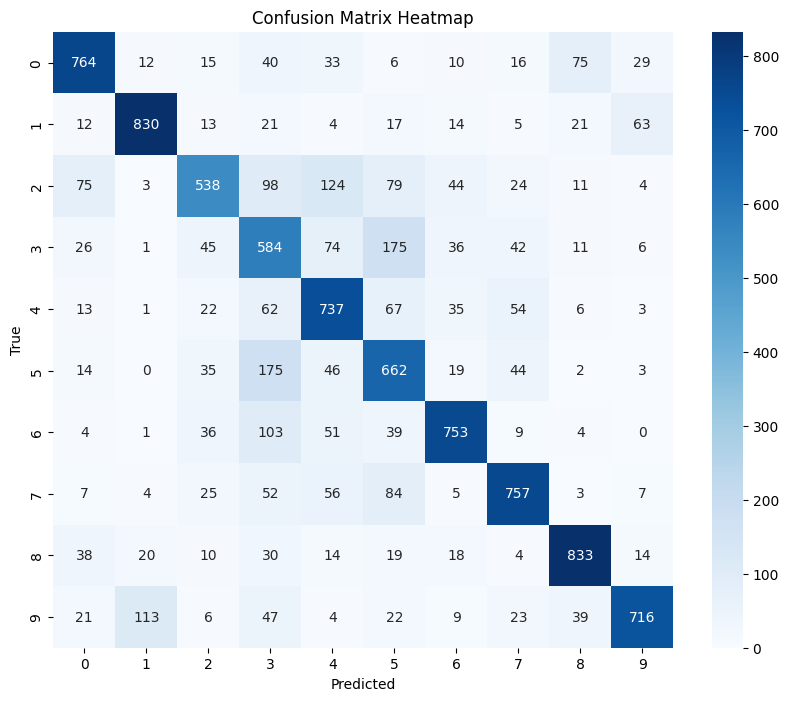

In [84]:
test(best_model_untrained, test_loader)

## Train and Test Model on Original Dataset (pretrained=True)


In [85]:
n_classes = len(torch.unique(train_lbl))
model_trained = resnet18(pretrained=True)
model_trained.fc = nn.Linear(model_trained.fc.in_features, n_classes)

/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [86]:
wandb.init(project="CV Assignment 2 - ResNet18 Models", name="Pretrained = True, Original Dataset", reinit=True)
best_model_trained = train(model_trained, train_loader, val_loader)
wandb.finish()

Training complete


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▃▃▁▇███▇█▆
val_loss,▅▅█▁▁▁▃▃▃▅
epoch,9
train_acc,96.3775
train_loss,0.10648
val_acc,77.28
val_loss,0.92529


Test Loss: 0.0152
Test Accuracy: 79.08%
Test F1 Score: 0.7893


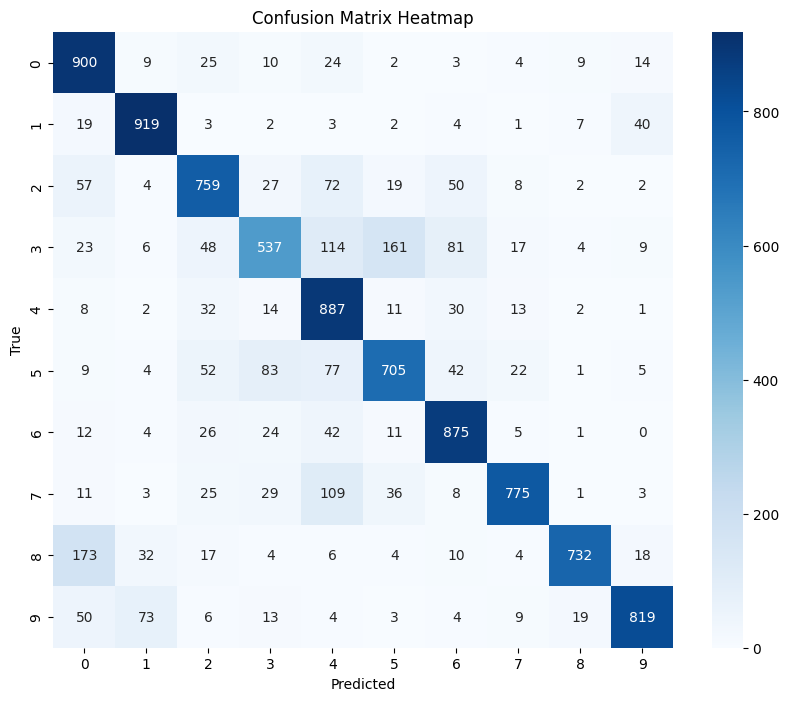

In [87]:
test(best_model_trained, test_loader)

## Train and Test Model on Scaled Dataset (pretrained=False)


In [88]:
n_classes = len(torch.unique(train_lbl))
model_untrained_scaled = resnet18(pretrained=False)
model_untrained_scaled.fc = nn.Linear(model_untrained_scaled.fc.in_features, n_classes)

/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [89]:
wandb.init(project="CV Assignment 2 - ResNet18 Models", name="Pretrained = False, Scaled Dataset", reinit=True)
best_model_untrained_scaled = train(model_untrained_scaled, train_loader, val_loader)
wandb.finish()

Training complete


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▅▆▇▇█▇███
val_loss,█▃▃▂▂▁▂▂▄▃
epoch,9
train_acc,93.94
train_loss,0.17067
val_acc,73.48
val_loss,1.05275


Test Loss: 0.0160
Test Accuracy: 74.22%
Test F1 Score: 0.7433


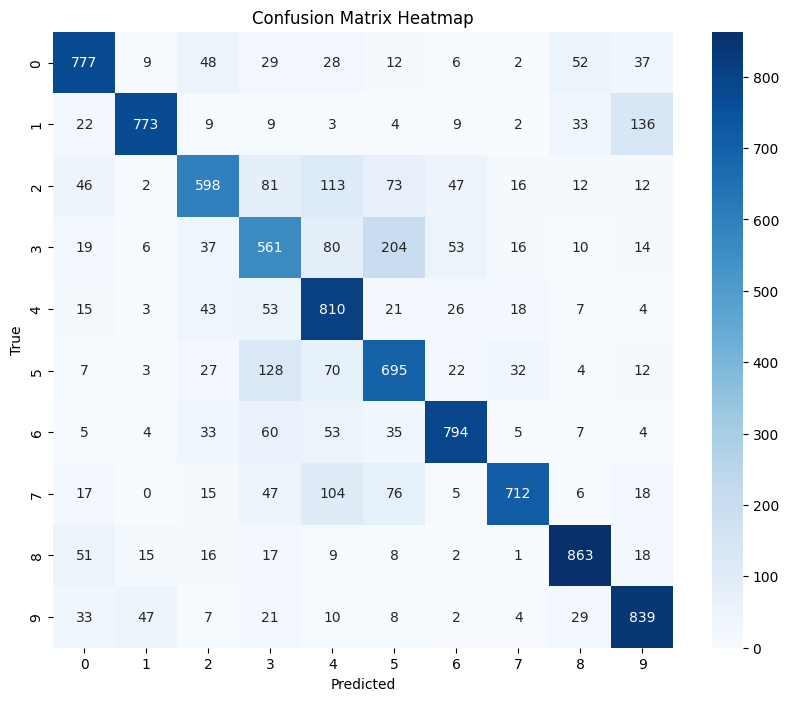

In [90]:
test(best_model_untrained_scaled, test_loader)

## Train and Test Model on Scaled Dataset (pretrained=True)


In [91]:
n_classes = len(torch.unique(train_lbl))
model_trained_scaled = resnet18(pretrained=True)
model_trained_scaled.fc = nn.Linear(model_trained_scaled.fc.in_features, n_classes)

/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [92]:
wandb.init(project="CV Assignment 2 - ResNet18 Models", name="Pretrained = True, Scaled Dataset", reinit=True)
best_model_trained_scaled = train(model_trained_scaled, train_loader, val_loader)
wandb.finish()

Training complete


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▃▂▃▃▃▁▄█▇█
val_loss,▁▂▁▂▅█▅▁▁▂
epoch,9
train_acc,96.3525
train_loss,0.10507
val_acc,81.37
val_loss,0.74282


Test Loss: 0.0168
Test Accuracy: 80.18%
Test F1 Score: 0.8040


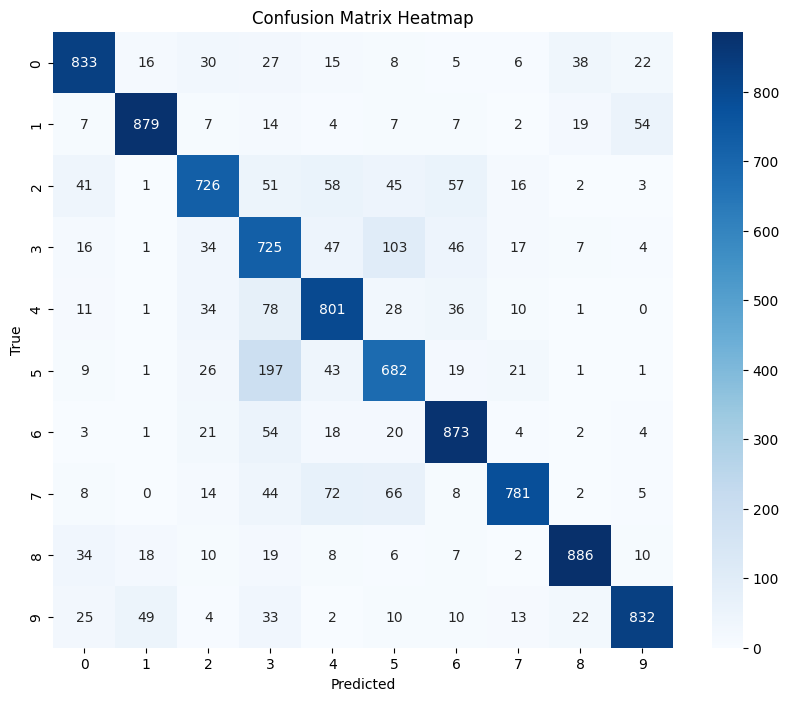

In [93]:
test(best_model_trained_scaled, test_loader)

## Unmodified Models Analysis

### Loss Plots

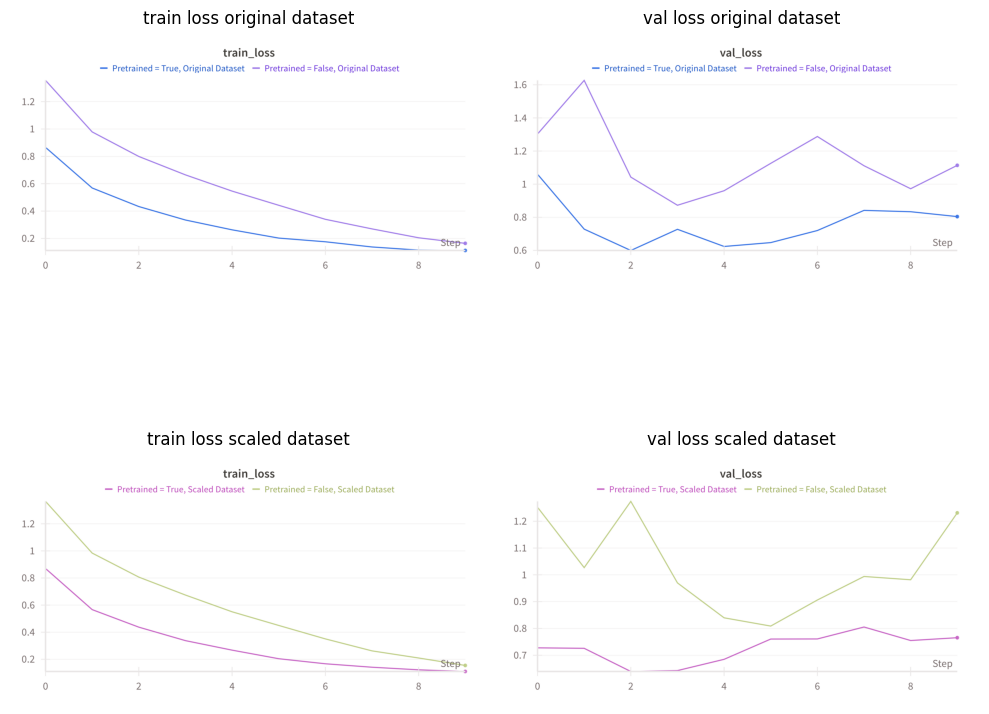

In [94]:
image_paths = ['./plots/train_loss_original_dataset.png', 
               './plots/val_loss_original_dataset.png', 
               './plots/train_loss_scaled_dataset.png', 
               './plots/val_loss_scaled_dataset.png']

titles = ['train loss original dataset', 
          'val loss original dataset', 
          'train loss scaled dataset', 
          'val loss scaled dataset']

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for ax, img_path, title in zip(axes.flatten(), image_paths, titles):
    img = cv2.imread(img_path)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Dimensional Analysis

In [95]:
def model_dimensions(model, image, title):
    print("Model: ", title)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image = image.float().to(device).unsqueeze(0)
    
    def hook_func(module, inp, out):
        if isinstance(module, (nn.Conv2d, nn.MaxPool2d, nn.AdaptiveAvgPool2d)):
            print(f'After {module.__class__.__name__}: {out.shape}')
    
    hooks = []
    for name, module in model.named_modules():
        hooks.append(module.register_forward_hook(hook_func))
        
    with torch.no_grad():
        output = model(image)
        
    for hook in hooks:
        hook.remove()

In [96]:
original_dataset_sample, _ = next(iter(test_loader))
original_dataset_sample = original_dataset_sample[0]
print(original_dataset_sample.shape)

torch.Size([3, 36, 36])


In [97]:
model_dimensions(best_model_untrained, original_dataset_sample, "Pretrained = False, Original Dataset")

Model:  Pretrained = False, Original Dataset
After Conv2d: torch.Size([1, 64, 18, 18])
After MaxPool2d: torch.Size([1, 64, 9, 9])
After Conv2d: torch.Size([1, 64, 9, 9])
After Conv2d: torch.Size([1, 64, 9, 9])
After Conv2d: torch.Size([1, 64, 9, 9])
After Conv2d: torch.Size([1, 64, 9, 9])
After Conv2d: torch.Size([1, 128, 5, 5])
After Conv2d: torch.Size([1, 128, 5, 5])
After Conv2d: torch.Size([1, 128, 5, 5])
After Conv2d: torch.Size([1, 128, 5, 5])
After Conv2d: torch.Size([1, 128, 5, 5])
After Conv2d: torch.Size([1, 256, 3, 3])
After Conv2d: torch.Size([1, 256, 3, 3])
After Conv2d: torch.Size([1, 256, 3, 3])
After Conv2d: torch.Size([1, 256, 3, 3])
After Conv2d: torch.Size([1, 256, 3, 3])
After Conv2d: torch.Size([1, 512, 2, 2])
After Conv2d: torch.Size([1, 512, 2, 2])
After Conv2d: torch.Size([1, 512, 2, 2])
After Conv2d: torch.Size([1, 512, 2, 2])
After Conv2d: torch.Size([1, 512, 2, 2])
After AdaptiveAvgPool2d: torch.Size([1, 512, 1, 1])


In [98]:
model_dimensions(best_model_trained, original_dataset_sample, "Pretrained = True, Original Dataset")

Model:  Pretrained = True, Original Dataset
After Conv2d: torch.Size([1, 64, 18, 18])
After MaxPool2d: torch.Size([1, 64, 9, 9])
After Conv2d: torch.Size([1, 64, 9, 9])
After Conv2d: torch.Size([1, 64, 9, 9])
After Conv2d: torch.Size([1, 64, 9, 9])
After Conv2d: torch.Size([1, 64, 9, 9])
After Conv2d: torch.Size([1, 128, 5, 5])
After Conv2d: torch.Size([1, 128, 5, 5])
After Conv2d: torch.Size([1, 128, 5, 5])
After Conv2d: torch.Size([1, 128, 5, 5])
After Conv2d: torch.Size([1, 128, 5, 5])
After Conv2d: torch.Size([1, 256, 3, 3])
After Conv2d: torch.Size([1, 256, 3, 3])
After Conv2d: torch.Size([1, 256, 3, 3])
After Conv2d: torch.Size([1, 256, 3, 3])
After Conv2d: torch.Size([1, 256, 3, 3])
After Conv2d: torch.Size([1, 512, 2, 2])
After Conv2d: torch.Size([1, 512, 2, 2])
After Conv2d: torch.Size([1, 512, 2, 2])
After Conv2d: torch.Size([1, 512, 2, 2])
After Conv2d: torch.Size([1, 512, 2, 2])
After AdaptiveAvgPool2d: torch.Size([1, 512, 1, 1])


### Impact of Resizing

- Larger image size implies more storage required to store the images, increased computation in the model, and longer to train
- scaling the images does not necessarily mean that it has the same information as the original image OR if original image was of the larger size, i.e. interpolation reduces the information in the image

## Modification 1 (pretrained=False)

Change filter size to 3x3 and remove maxpool

In [19]:
n_classes = len(torch.unique(train_lbl))
model_untrained_v1 = resnet18(pretrained=False)
model_untrained_v1.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
model_untrained_v1.maxpool == nn.Identity()
model_untrained_v1.fc = nn.Linear(model_untrained_v1.fc.in_features, n_classes)

/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [20]:
wandb.init(project="CV Assignment 2 - ResNet18 Models", name="Pretrained = False, Modification 1", reinit=True)
best_model_untrained_v1 = train(model_untrained_v1, train_loader, val_loader)
wandb.finish()

wandb: Currently logged in as: devika-bej (devika-bej-international-institute-of-information-techno) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Training complete


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▄▃▂▂▁▁▁
val_acc,▁▅▇▅▇▇███▇
val_loss,█▄▁▅▂▃▁▃▄▆
epoch,9
train_acc,96.6475
train_loss,0.09714
val_acc,76.5
val_loss,0.99464


Test Loss: 0.0133
Test Accuracy: 74.05%
Test F1 Score: 0.7404


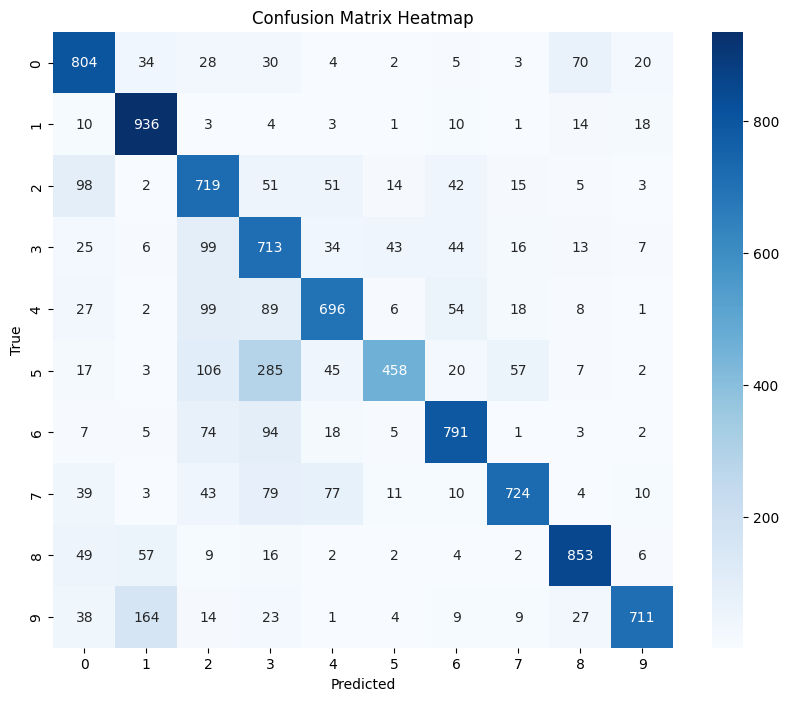

In [21]:
test(best_model_untrained_v1, test_loader)

## Modification 2 (pretrained=False)

Break conv1 into two convolutions

In [22]:
n_classes = len(torch.unique(train_lbl))
model_untrained_v2 = resnet18(pretrained=False)
model_untrained_v2.conv1 = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(inplace=True)
)
model_untrained_v2.fc = nn.Linear(model_untrained_v2.fc.in_features, n_classes)

/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [23]:
wandb.init(project="CV Assignment 2 - ResNet18 Models", name="Pretrained = False, Modification 2", reinit=True)
best_model_untrained_v2 = train(model_untrained_v2, train_loader, val_loader)
wandb.finish()

Training complete


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▅▆▇▇███
train_loss,█▅▄▄▃▂▂▁▁▁
val_acc,▁▃▅▇▇█▆██▇
val_loss,█▆▅▁▂▁▇▅▅█
epoch,9
train_acc,95.6425
train_loss,0.12315
val_acc,74.64
val_loss,1.05787


Test Loss: 0.0160
Test Accuracy: 76.01%
Test F1 Score: 0.7589


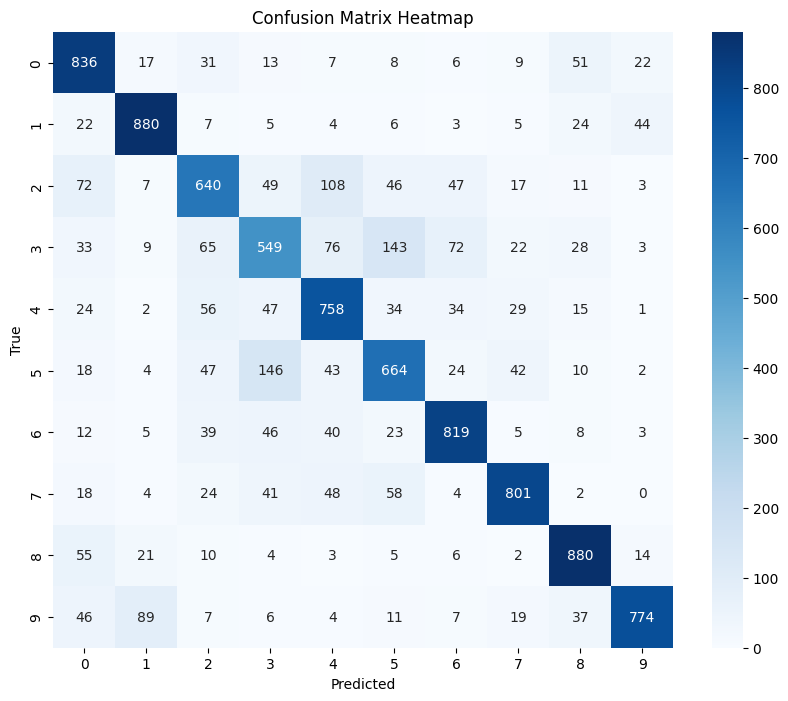

In [24]:
test(best_model_untrained_v2, test_loader)

## Modification 3 (pretrained=False)

Break conv1 into two convoliutions and remove maxpool

In [25]:
n_classes = len(torch.unique(train_lbl))
model_untrained_v3 = resnet18(pretrained=False)
model_untrained_v3.conv1 = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(inplace=True)
)
model_untrained_v3.maxpool = nn.Identity()
model_untrained_v3.fc = nn.Linear(model_untrained_v3.fc.in_features, n_classes)

/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [26]:
wandb.init(project="CV Assignment 2 - ResNet18 Models", name="Pretrained = False, Modification 3", reinit=True)
best_model_untrained_v3 = train(model_untrained_v3, train_loader, val_loader)
wandb.finish()

Training complete


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▆▇▇███
train_loss,█▆▄▃▃▂▂▁▁▁
val_acc,▁▄▆▇▇█▇█▇▇
val_loss,█▅▃▂▁▁▄▃▅▄
epoch,9
train_acc,96.295
train_loss,0.10371
val_acc,76.03
val_loss,0.9929


Test Loss: 0.0156
Test Accuracy: 77.85%
Test F1 Score: 0.7777


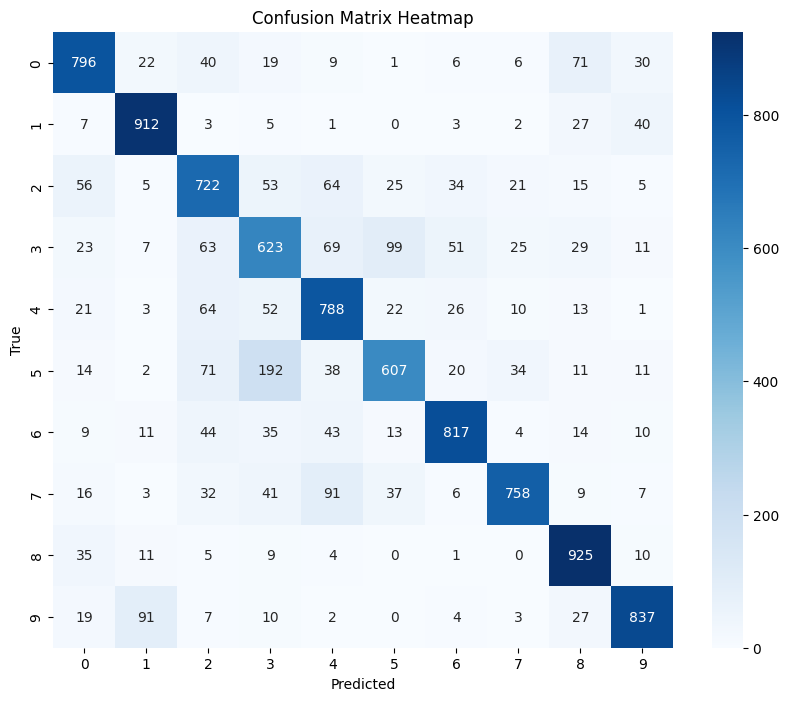

In [27]:
test(best_model_untrained_v3, test_loader)

## Modification 1 (pretrained=True)

Change filter size to 3x3 and remove maxpool

In [28]:
n_classes = len(torch.unique(train_lbl))
model_trained_v1 = resnet18(pretrained=True)
model_trained_v1.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
nn.init.kaiming_normal_(model_trained_v1.conv1.weight, mode='fan_out', nonlinearity='relu')
model_trained_v1.maxpool == nn.Identity()
model_trained_v1.fc = nn.Linear(model_trained_v1.fc.in_features, n_classes)

/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
wandb.init(project="CV Assignment 2 - ResNet18 Models", name="Pretrained = True, Modification 1", reinit=True)
best_model_trained_v1 = train(model_trained_v1, train_loader, val_loader)
wandb.finish()

Training complete


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▇▇████
train_loss,█▅▄▃▂▂▁▁▁▁
val_acc,▁▅▅▇█▇▇▇▇▆
val_loss,▇▂▃▁▁▃▄▄▅█
epoch,9
train_acc,97.245
train_loss,0.08035
val_acc,79.1
val_loss,0.93325


Test Loss: 0.0141
Test Accuracy: 81.49%
Test F1 Score: 0.8124


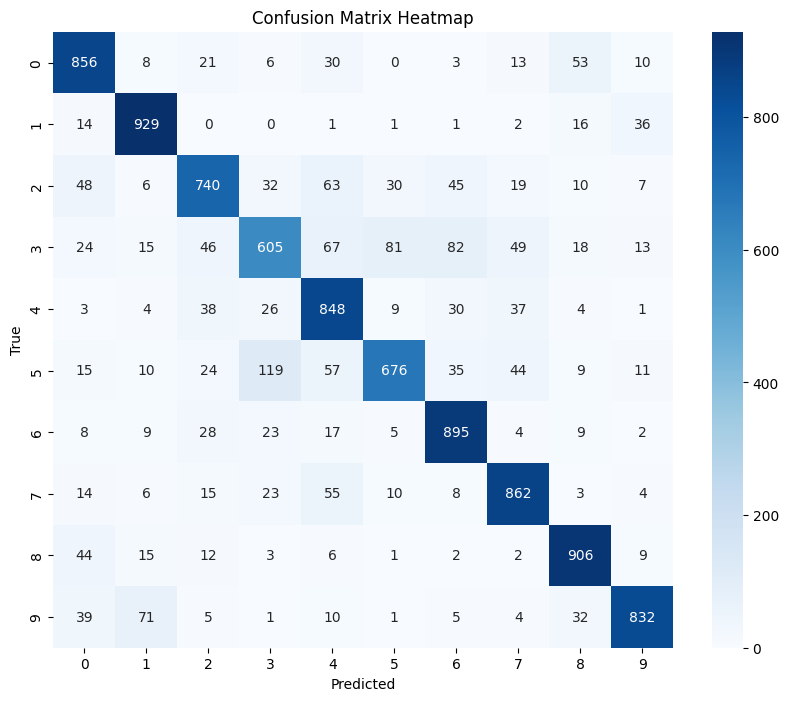

In [30]:
test(best_model_trained_v1, test_loader)

## Modification 2 (pretrained=True)

Break conv1 into two convolutions

In [31]:
n_classes = len(torch.unique(train_lbl))
model_trained_v2 = resnet18(pretrained=True)
model_trained_v2.conv1 = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(inplace=True)
)
for layer in model_trained_v2.conv1:
    if isinstance(layer, nn.Conv2d):
        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
model_trained_v2.fc = nn.Linear(model_trained_v2.fc.in_features, n_classes)

/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
wandb.init(project="CV Assignment 2 - ResNet18 Models", name="Pretrained = True, Modification 2", reinit=True)
best_model_trained_v2 = train(model_trained_v2, train_loader, val_loader)
wandb.finish()

Training complete


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▇▇█▇▇▇██
val_loss,█▅▂▁▁▅▅▅▅▆
epoch,9
train_acc,95.595
train_loss,0.13039
val_acc,76.06
val_loss,0.9777


Test Loss: 0.0148
Test Accuracy: 74.59%
Test F1 Score: 0.7427


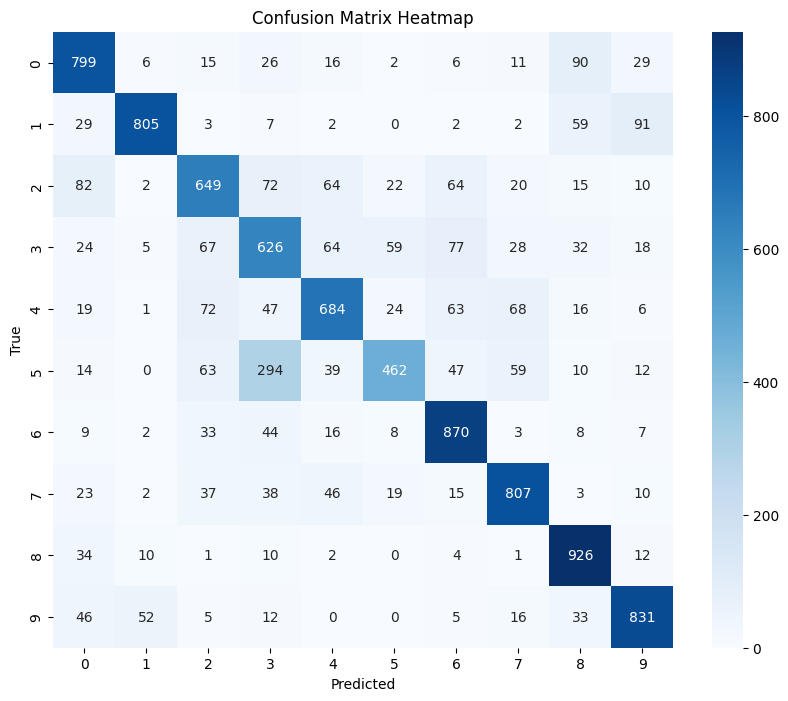

In [33]:
test(best_model_trained_v2, test_loader)

## Modification 3 (pretrained=True)

Break conv1 into two convolutions and remove maxpool

In [34]:
n_classes = len(torch.unique(train_lbl))
model_trained_v3 = resnet18(pretrained=True)
model_trained_v3.conv1 = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(inplace=True)
)
for layer in model_trained_v3.conv1:
    if isinstance(layer, nn.Conv2d):
        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
model_trained_v3.maxpool = nn.Identity()
model_trained_v3.fc = nn.Linear(model_trained_v3.fc.in_features, n_classes)

/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/devika/personal/assignment-2-devika-bej/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
wandb.init(project="CV Assignment 2 - ResNet18 Models", name="Pretrained = True, Modification 3", reinit=True)
best_model_trained_v3 = train(model_trained_v3, train_loader, val_loader)
wandb.finish()

Training complete


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▇▇████
train_loss,█▅▄▃▂▂▁▁▁▁
val_acc,▁▅▇▅▆▇▇█▇█
val_loss,█▄▁▄▄▄▆▅█▆
epoch,9
train_acc,96.9975
train_loss,0.08661
val_acc,80.92
val_loss,0.8179


Test Loss: 0.0135
Test Accuracy: 78.74%
Test F1 Score: 0.7869


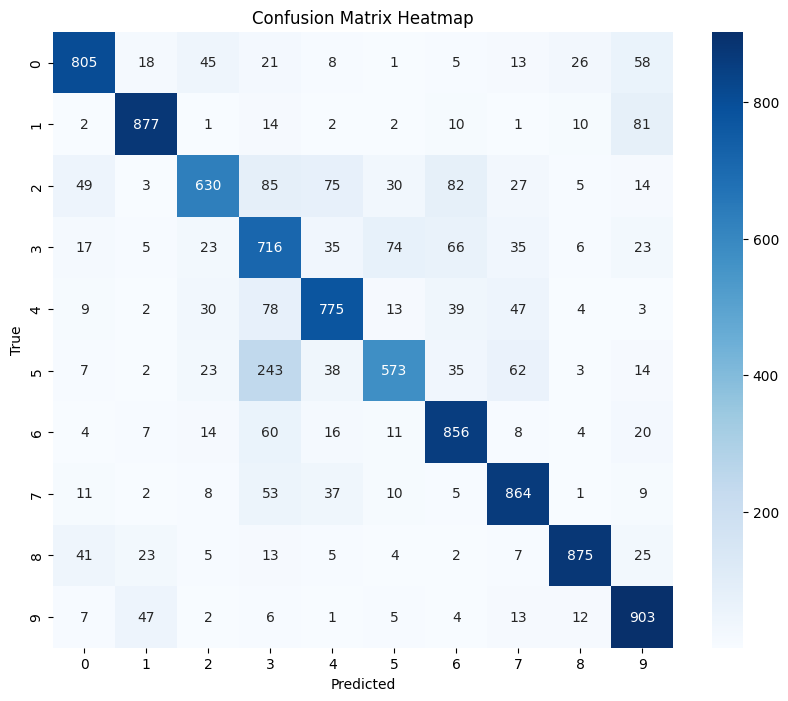

In [36]:
test(best_model_trained_v3, test_loader)

## Modified Models Analysis

### Loss Plots

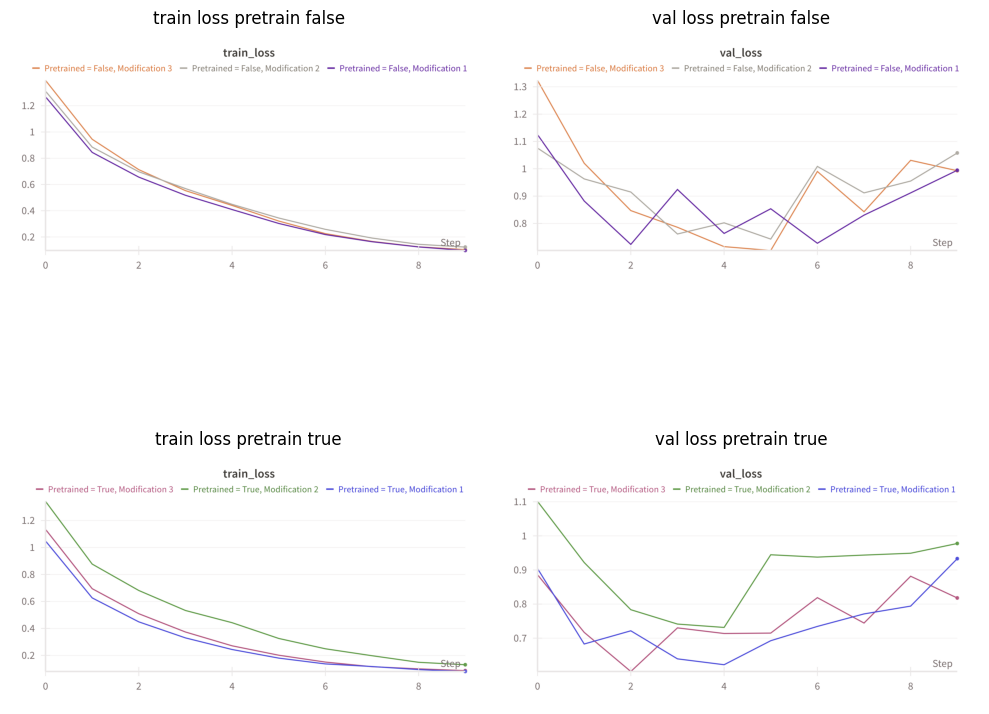

In [37]:
image_paths = ['./plots/train_loss_pretrain_false.png', 
               './plots/val_loss_pretrain_false.png', 
               './plots/train_loss_pretrain_true.png', 
               './plots/val_loss_pretrain_true.png']

titles = ['train loss pretrain false', 
          'val loss pretrain false', 
          'train loss pretrain true', 
          'val loss pretrain true']

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for ax, img_path, title in zip(axes.flatten(), image_paths, titles):
    img = cv2.imread(img_path)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Initializing first layer from scratch - a problem?

- The method used to initialize the conv1 layers of the model was Kaiming Normal Initialization
- It is a method commonly used to initialize NN weights as it takes care of vanishing and exploding gradients
- However, given that these weights are in a different distribution as compared to the fine tuned weights of the following layers, the network would have to adapt these weights before reaching a proper convergence, slowing the training
- Additionally, there may be a difference in the features which these weights extract as compared to the features the rest of the network expects (the features extracted by the weights fine tuned by a larger dataset)

## All Models Analysis

### Tabular Results

| Pretrained | Input Size | Modification                          | Test Loss | Test Accuracy | Test F1  |
|------------|------------|---------------------------------------|-----------|---------------|----------|
| False      | Original   | None                                  | 0.0199          | 71.74%              | 0.7201         |
| True       | Original   | None                                  | 0.0152          | 79.08%              | 0.7893         |
| False      | Scaled     | None                                  | 0.0160          | 74.22%              | 0.7433         |
| True       | Scaled     | None                                  | 0.0168          | 80.18%              | 0.8040         |
| False      | Original   | Change filter size to 3x3, remove maxpool | 0.0133          | 74.05%              | 0.7404         |
| False      | Original   | Break conv1 into two convolutions     | 0.0160          | 76.01%              | 0.7589         |
| False      | Original   | Break conv1 into two convolutions, remove maxpool | 0.0156          | 77.85%              | 0.7777         |
| True       | Original   | Change filter size to 3x3, remove maxpool | 0.0141          | 81.49%              | 0.8124         |
| True       | Original   | Break conv1 into two convolutions     | 0.0148          | 74.59%              | 0.7427         |
| True       | Original   | Break conv1 into two convolutions, remove maxpool | 0.0135          | 78.74%              | 0.7869         |

### Observations

#### Effect of pretrained weights
- Overall, the usage of pretrained weights as initial weights consistently performs better
- This is because these weights are already fine tuned for extracting useful features from a larger and more generic dataset of images
- Training it on this smaller dataset and testing it only makes it more finetuned (at risk of overfitting) to this specific set of images

#### Effect of input size
- When the input image is 224x224, the model generally performs better than when input image is 36x36
- This is because even if the interpolated image doesn't have additional information, the larger size essentially acts like a sort of zoom, making the feature extraction of the model better

#### Effect of removing maxpool layer
- Removing the maxpool layer very clearly improves the performance of the model
- Note that after the maxpool layer, the dimensions of the image go down from 36x36 to 9x9
- This huge drop in size also translates to possibly losing some information which gets maintained upon removing the maxpool layer
- The v1 and v3 modified models take advantage of this and perform much better